In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool


### This notebook processes shrug data into the shapefiles ready for downstream analysis.

This notebook aggreagtes features from the MOSAIKS API (siml.berkeley.edu) into per-region features. Since the shrug dataset is so large, this is done slightly differently than for the other countries. 

In [67]:
# at what threshold to merge rural regions until 
sq_km_thresh= 25
data_dir_shrug = '/data/mosaiks/shrug/'

# wherever the features are stored after download from the API
FEATURES_INFOLDER =  '/data/mosaiks/sampled_tiles/india/featurized/esther_request/'
TILES_FOLDER = '/data/mosaiks/replication/sampled_tiles/india'

max_tiles = 100

if max_tiles is None:
    feats_save_fp = f'/data/mosaiks/replication/features/mosaiks_features_by_shrug_condensed_regions_{sq_km_thresh}_india.csv'
    meta_save_fp = f'/data/mosaiks/replication/sampled_tiles/india/shrug_condensed_regions_{sq_km_thresh}_meta.csv'
    feats_save_fp_1 = f'/data/mosaiks/replication/features_1_tile_per_region/mosaiks_features_by_shrug_condensed_regions_{sq_km_thresh}_india.csv'
    meta_save_fp_1 = f'/data/mosaiks/replication/sampled_tiles/india/one_tile_per_resion_shrug_condensed_regions_{sq_km_thresh}_meta.csv'
else:
    feats_save_fp = f'/data/mosaiks/replication/features/mosaiks_features_by_shrug_condensed_regions_{sq_km_thresh}_max_tiles_{max_tiles}_india.csv'
    meta_save_fp = f'/data/mosaiks/replication/sampled_tiles/india/shrug_condensed_regions_{sq_km_thresh}_max_tiles_{max_tiles}_meta.csv'
    feats_save_fp_1 = f'/data/mosaiks/replication/features_1_tile_per_region/mosaiks_features_by_shrug_condensed_regions_{sq_km_thresh}_india_max_tiles_{max_tiles}.csv'
    meta_save_fp_1 = f'/data/mosaiks/replication/sampled_tiles/india/one_tile_per_resion_shrug_condensed_regions_{sq_km_thresh}_max_tiles_{max_tiles}_meta.csv'

## Assign MOSAIKS tiles to each unit.
Assumes you have already downloaded the relevant MOSAIKS tiles from the API. See `2a_satellite_sampling.ipynb` notebook to generate csv as input to the MOSAIKS API.

In [47]:
def get_as_one_sample(aggreated_shapefile_row, max_tiles=None, random_state=None):
    # ignore the weight column in the condensed csvs and read from the original sample
    # get all shrids in this one
    shrug_idxs = aggreated_shapefile_row['shrids_merged_str'].split(',')

    # read fps and weights from the big csv
    samples =[]
    for shrug_idx in shrug_idxs:
        this_sample = pd.read_csv(f'{TILES_FOLDER}/{shrug_idx}')
        samples.append(this_sample)
    samples = pd.concat(samples,ignore_index=True)

    # round to nearest 3 so lat and lon are consistent
    samples[['Latitude','Longitude']]= samples[['Latitude','Longitude']].apply(lambda x: x.round(3))
    # add weights for any repeated lat/lon pairs
    s = samples.groupby(['Latitude','Longitude'], as_index=False)['weight'].sum()
    num_eligible_tiles = len(s)
    # limit to the maximum number of tiles, if applicable
    if max_tiles is not None and len(s) > max_tiles:
        s = s.sample(max_tiles, replace=False, random_state=random_state)
    
    return s, num_eligible_tiles


def merge_with_mosaiks_references(sample):
    keys = ['Latitude','Longitude','weight', 'fp', 'index_within_chunk']
    return sample.merge(latlons, on=['Latitude','Longitude'],how='inner')[keys]

def aquire_and_average_features(sample_with_fps, max_tiles=None):
    # group by fp so we don't read the same path many times 
    s_by_fp = sample_with_fps.groupby('fp')

    if (len(s_by_fp.groups.items())) == 0: 
        print('no tiles')
        return [], 0

    mosaiks_tiles_by_chunk = []
    weights_by_chunk = []
    for chunk_fp, idxs in s_by_fp.groups.items():
        idxs_within_chunk = s_by_fp.get_group(chunk_fp)['index_within_chunk']
        this_chunk = pd.DataFrame(np.load(chunk_fp)[idxs_within_chunk])
        mosaiks_tiles_by_chunk.append(this_chunk)
        weights_by_chunk.append(s_by_fp.get_group(chunk_fp)['weight'])
        
    mosaiks_tiles = pd.concat(mosaiks_tiles_by_chunk)

    feature_colnames = ['Feature' + str(i) for i in range(4000)]
    mosaiks_tiles.columns = ['Latitude', 'Longitude'] + feature_colnames
    mosaiks_tiles.loc[:,'weight'] = pd.concat(weights_by_chunk)
    x_avged = np.average(a = mosaiks_tiles[feature_colnames].values,
                         weights = mosaiks_tiles['weight'].values,
                         axis=0)
    
    return x_avged, len(mosaiks_tiles)

def process_row(args):
    # wrapper function to work with parallelization
    if len(args) == 3:
        row, max_tiles_per_region, i = args
        # random seed for sampling tiles determined by index 
        rs = np.random.RandomState(i)
    else:
        row = args
        rs = None
        max_tiles_per_region = None
        
    # compile each shapefile in this row to one sample
    s, num_eligible_tiles = get_as_one_sample(row, max_tiles = max_tiles_per_region, random_state=rs)
    # add in fps to mosaiks feats
    s_with_fp = merge_with_mosaiks_references(s)
    # average the feats
    feats, num_tiles_in_avg = aquire_and_average_features(s_with_fp)

    # if missing any tiles in the feature average, track that they are missing because they 
    # weren't in the feature set to begin with
    if num_tiles_in_avg != len(s):
        not_found_tiles = pd.concat((s[['Latitude','Longitude']],
                       s_with_fp[['Latitude','Longitude']])).drop_duplicates(keep=False)
        
        n_tiles_not_in_mosaiks_corpus = len(not_found_tiles.merge(unfound_rows, 
                                                                     how='inner', 
                                                                     on = ['Latitude','Longitude']))
    else:
        n_tiles_not_in_mosaiks_corpus = 0
    
    return row['condensed_shrug_id'], feats, num_eligible_tiles, num_tiles_in_avg, n_tiles_not_in_mosaiks_corpus



In [48]:
def get_latlons(features_infolder, overwrite = False):
    # read all latlons for features in features_infolder, and save them all together
    # with the fps and idxs within each chunk of the features
    if 'all_latlons.csv' in os.listdir(features_infolder) and not overwrite:
        return pd.read_csv(features_infolder + '/'+ 'all_latlons.csv')
    
    chunks = []
    for i,fname in enumerate(os.listdir(features_infolder)):
        if fname == 'all_latlons.csv': continue # ignore this to overwrite
        fp = features_infolder + '/'+ fname
        this_chunk = pd.DataFrame(np.load(fp)[:,:2])

        this_chunk.columns = ['Latitude', 'Longitude'] 
        this_chunk.loc[:,'fp'] = fp
        this_chunk.loc[:,'index_within_chunk'] = this_chunk.index
        chunks.append(this_chunk)

        latlons = pd.concat(chunks)
        latlons.loc[:,['Latitude', 'Longitude']] = latlons.loc[:,['Latitude', 'Longitude']].round(3)
    print('writing to ',features_infolder + '/'+ 'all_latlons.csv')
    latlons.to_csv(features_infolder + '/'+ 'all_latlons.csv')
    
    return latlons

def get_unfound_rows(features_infolder):
  
    latlons = get_latlons(features_infolder, overwrite=False)    
    sample_sent = pd.read_csv('/data/mosaiks/shrug/shrug_sample/sampled_tiles_unique.csv')
    sample_sent.columns =['Latitude','Longitude']

    df_together = pd.concat((sample_sent,latlons))
    unfound_rows = df_together.drop_duplicates(['Latitude','Longitude'],keep=False)
    return unfound_rows
 


## 3.2 compile, check on any missing cells 
Make sure that missing cells are explained by that cell actually being missing in the MOSAIKS features

In [20]:
shapefile_name = os.path.join(data_dir_shrug,
                              f'shrug_condensed_regions_{sq_km_thresh}.geojson')

shapefile = gpd.read_file(shapefile_name)
print(shapefile_name)
print(len(shapefile))

/data/mosaiks/shrug/shrug_condensed_regions_25.geojson
63356


In [12]:
t1 = time.time()
latlons = get_latlons(FEATURES_INFOLDER, overwrite=False)
t2 = time.time()
print(f'{t2-t1:.3f}')

1.256


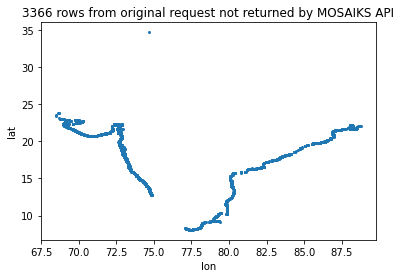

In [44]:
# track rows not in the mosaiks API
unfound_rows = get_unfound_rows(FEATURES_INFOLDER)

plt.scatter(unfound_rows['Longitude'],unfound_rows['Latitude'],s=4)
plt.title(f'{len(unfound_rows)} rows from original request not returned by MOSAIKS API')
plt.xlabel('lon')
plt.ylabel('lat');

In [45]:
if max_tiles is None:
    todo_list = [shapefile.iloc[i] for i in range(len(shapefile))]
else:
    todo_list = [[shapefile.iloc[i], max_tiles, i] for i in range(len(shapefile))]

In [ ]:
'/data/mosaiks/replication/sampled_tiles/india/sampled_tiles_partition_0.csv'


In [46]:
latlons.iloc[0]['fp']

'/data/mosaiks/sampled_tiles/india/featurized/esther_request//150.npy'

In [ ]:
# chunk into four to track timing
results_all = []
n_per_chunk = 16000
n_processes = 40
chunks = int(len(todo_list) / n_per_chunk) + 1
for i in range(chunks):
    t1 = time.time()
    pool = Pool(n_processes)
    results_this_chunk = pool.map(process_row, todo_list[n_per_chunk*i:n_per_chunk*(i+1)])
    results_all.append(results_this_chunk)
    t2 = time.time()
    print(f'took : {(t2-t1)/60 /60} hours')

In [58]:
len(results_all)

4

In [60]:
# read in results 
no_samples = []
feats = []
shrug_condensed_idxs = []

unequal_num_samples = []
unequal_num_sample_idxs = []

missing_tiles_apart_from_api = []
missing_tiles_apart_from_api_idxs = []
num_tiles = []
num_tiles_asked = []

for results in results_all:
    for i,r in enumerate(results):
        if r[3] == 0: 
            no_samples.append(i)
        else:
            if r[2] != r[3]: 
                unequal_num_samples.append(r[0])
                unequal_num_sample_idxs.append(i)
                
            if r[2] - r[3] != r[4]:
                missing_tiles_apart_from_api.append(r[0])
                missing_tiles_apart_from_api_idxs.append(i)
            shrug_condensed_idxs.append(r[0])
            feats.append(r[1])
            num_tiles.append(r[3])
            num_tiles_asked.append(r[2])


In [79]:
meta = pd.DataFrame(np.array([shrug_condensed_idxs[:,0], num_tiles_asked, num_tiles]).T,
                     columns = ['shrug_condensed_id','num_eligible_squares', 'count'])
print(meta_save_fp)
meta.to_csv(meta_save_fp)

/data/mosaiks/replication/sampled_tiles/india/shrug_condensed_regions_25_max_tiles_100_meta.csv


In [62]:
print(f'thresh = {sq_km_thresh} km^2')
print(f'number of units = {len(shapefile)}')
print(f'pct rural units = {shapefile["rural"].mean()*100}')
print(f'pct urban units = {(1-shapefile["rural"].mean())*100}')


thresh = 25 km^2
number of units = 63356
pct rural units = 94.43778016288907
pct urban units = 5.562219837110927


In [63]:
print(f'thresh = {sq_km_thresh} km^2')
print('of cells with tiles:')
print(f'min num samples per unit: {np.min(num_tiles)}')
print(f'average num samples per unit: {np.mean(num_tiles)}')
print(f'max num samples per unit: {np.max(num_tiles)}')

thresh = 25 km^2
of cells with tiles:
min num samples per unit: 1
average num samples per unit: 49.02524072612471
max num samples per unit: 100


In [64]:
# sanity check any missingness
print(f'{len(no_samples)} of {len(shapefile)} had no tiles, of the rest:')
print(f'{len(unequal_num_samples)} had fewer tiles than requested')
print(f'{len(missing_tiles_apart_from_api)} had missing tiles apart from those not returned from API')


6 of 63356 had no tiles, of the rest:
3120 had fewer tiles than requested
2562 had missing tiles apart from those not returned from API


## 3.3 package for export to feature matrix

In [65]:
feature_colnames = ['Feature' + str(i) for i in range(4000)]
df_columns = ['condensed_shrug_id'] + feature_colnames 

shrug_condensed_idxs = np.array(shrug_condensed_idxs).reshape(-1,1)
feats = np.array(feats)
feats_all = pd.DataFrame(np.hstack((shrug_condensed_idxs,feats)), columns = df_columns)

In [68]:
print(feats_all.shape)
print(f'writing to {feats_save_fp}')
feats_all.to_csv(feats_save_fp,index=False)

(63350, 4001)
writing to /data/mosaiks/replication/features/mosaiks_features_by_shrug_condensed_regions_25_max_tiles_100_india.csv


In [70]:
sq_km_thresh = 25
shrug_csv_fp_after_merge = os.path.join(data_dir_shrug,
                              f'shrug_condensed_regions_{sq_km_thresh}.geojson')

# load gdf and add projected area
gdf_after_merge = gpd.read_file(shrug_csv_fp_after_merge)


In [71]:
gdf_urban = gdf_after_merge[gdf_after_merge.rural == False]
gdf_rural = gdf_after_merge[gdf_after_merge.rural == True]

In [72]:
print(f'AFTER MERGE')
print(f'there are {len(gdf_urban)} urban shrids')
print(f'there are {len(gdf_rural)} rural shrids before merging')
print(f'median area of urban regions: {np.median(gdf_urban.proj_area) / 1e6} km^2')
print(f'median area of rural regions: {np.median(gdf_rural.proj_area) / 1e6} km^2')

AFTER MERGE
there are 3524 urban shrids
there are 59832 rural shrids before merging
median area of urban regions: 13.919551831449446 km^2
median area of rural regions: 40.84049456779559 km^2


# 3. get 1 tile at a time for tile analysis

In [85]:
max_tiles = 1
if max_tiles is None:
    todo_list = [shapefile.iloc[i] for i in range(len(shapefile))]
else:
    todo_list = [[shapefile.iloc[i], max_tiles, i] for i in range(len(shapefile))]

In [ ]:
# chunk into four to track timing
results_all_1 = []
n_per_chunk = 16000
n_processes = 40
chunks = int(len(todo_list) / n_per_chunk) + 1
for i in range(chunks):
    t1 = time.time()
    pool = Pool(n_processes)
    results_this_chunk_1 = pool.map(process_row, todo_list[n_per_chunk*i:n_per_chunk*(i+1)])
    results_all_1.append(results_this_chunk_1)
    t2 = time.time()
    print(f'took : {(t2-t1)/60 /60} hours')

no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles
no tiles


In [ ]:
# read in results 
no_samples = []
feats = []
shrug_condensed_idxs = []

unequal_num_samples = []
unequal_num_sample_idxs = []

missing_tiles_apart_from_api = []
missing_tiles_apart_from_api_idxs = []
num_tiles = []
num_tiles_asked = []

for results in results_all_1:
    for i,r in enumerate(results):
        if r[3] == 0: 
            no_samples.append(i)
        else:
            if r[2] != r[3]: 
                unequal_num_samples.append(r[0])
                unequal_num_sample_idxs.append(i)
                
            if r[2] - r[3] != r[4]:
                missing_tiles_apart_from_api.append(r[0])
                missing_tiles_apart_from_api_idxs.append(i)
            shrug_condensed_idxs.append(r[0])
            feats.append(r[1])
            num_tiles.append(r[3])
            num_tiles_asked.append(r[2])


In [ ]:
# package as meta data
meta = pd.DataFrame(np.array([shrug_condensed_idxs, num_tiles_asked, num_tiles]).T,
                     columns = ['shrug_condensed_id','num_eligible_squares', 'count'])
meta.to_csv(meta_save_fp_1)

In [ ]:
feature_colnames = ['Feature' + str(i) for i in range(4000)]
df_columns = ['condensed_shrug_id'] + feature_colnames 

shrug_condensed_idxs = np.array(shrug_condensed_idxs).reshape(-1,1)
feats = np.array(feats)
feats_all_1 = pd.DataFrame(np.hstack((shrug_condensed_idxs,feats)), columns = df_columns)

print(f'writing to {feats_save_fp_1}')
feats_all_1.to_csv(feats_save_fp_1,index=False)

In [ ]:
len(feats_all_1)